# NUMERO DE PRUEBA

In [ ]:
TRIAL_NUMBER = 'modelo1_trial_100epochs'



# Dependencias

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import LayerNormalization, Activation, Input, Dropout, Flatten, LeakyReLU, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed,Conv1D, Conv2D,Conv2DTranspose, AveragePooling1D
from tensorflow.keras.layers import MaxPooling1D, UpSampling1D, ZeroPadding1D, Lambda, Add, Cropping1D, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow import convert_to_tensor
from keras.callbacks import ReduceLROnPlateau

import os, random
import numpy as np
import progressbar
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import pickle

from functools import partial
from IPython import display
from tensorflow.keras.utils import plot_model
from scipy.io import loadmat
from scipy.signal import butter, lfilter, resample
import pandas as pd

from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#GLOBAL VARIABLES
csv_file = pd.read_csv('/content/drive/My Drive/TFM_DATA/Dx_snomed_valid.csv', delimiter = ';')
DATASET = 'm1.pkl'
DRIVE_PATH = '/content/drive/My Drive/TFM_DATA/'
RESULTS_PATH = '/content/drive/My Drive/TFM_RESULTS'
FILE_NAME = 'trial_details.txt'
TRIAL_PATH = str(os.path.join(RESULTS_PATH,TRIAL_NUMBER))

try:
  os.mkdir(TRIAL_PATH)
except:
  print(f'The file test {TRIAL_NUMBER} already exist, if you continue the\
  current test will be overrided, change the TRIAL_NUMBER to create a new\
  test.')

The file test modelo1_trial_100epochs already exist, if you continue the  current test will be overrided, change the TRIAL_NUMBER to create a new  test.


# Clasificación

In [ ]:
import pickle
dataset = pickle.load(open(str(os.path.join(DRIVE_PATH, DATASET)), 'rb'))
dataset['lead'] = dataset['lead'].astype(int)
dataset.shape

(549801, 6)

In [ ]:
dataset.head()

,file,age,sex,lead,ecg,class
0,A2593,77,0,0,"[0.3174895382126915, 0.5613913977688859, 0.533...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,A2593,77,0,0,"[0.16593204474768233, 0.1653932937071092, 0.15...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,A2593,77,0,0,"[0.19389642099122834, 0.23133741213525108, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,A2593,77,0,0,"[0.15553755632018673, 0.08410038837372408, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,A2593,77,0,0,"[0.12561890850507518, 0.13566250040069652, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


# Train Validation Test Splitting

In [ ]:
def transform_dims(sample):
  lista = []
  [lista.append(x) for x in sample]
  lista = np.array(lista)
  
  return lista

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

X, y = dataset[['age', 'sex','lead', 'ecg']], dataset[['class']]

Data_train, Data_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=42)

Data_val, Data_test, y_val, y_test = train_test_split(Data_val,
                                                      y_val,
                                                      test_size=0.5,
                                                      shuffle=True,
                                                      random_state=42)

# Transformamos los datos datos de train para hacerlos compatibles con Keras
X_train, qual_train = Data_train[['ecg']], Data_train[['age', 'sex','lead']]
X_train = np.squeeze(np.array(X_train))
y_train = np.squeeze(np.array(y_train))

X_train = transform_dims(X_train)
y_train = transform_dims(y_train)

X_train = np.expand_dims(X_train,1)

print('------TRAIN------')
print(X_train.shape)
print(qual_train.shape)
print(y_train.shape)

# Transformamos los datos datos de train para hacerlos compatibles con Keras
X_val, qual_val = Data_val[['ecg']], Data_val[['age', 'sex','lead']]
X_val = np.squeeze(np.array(X_val))
y_val = np.squeeze(np.array(y_val))

X_val = transform_dims(X_val)
y_val = transform_dims(y_val)

X_val = np.expand_dims(X_val,1)


print('------VAL------')
print(X_val.shape)
print(qual_val.shape)
print(y_val.shape)

# Transformamos los datos de test para hacerlos compatibles con Keras
X_test, qual_test = Data_test[['ecg']], Data_test[['age', 'sex','lead']]

X_test = np.squeeze(np.array(X_test))
y_test = np.squeeze(np.array(y_test))

X_test = transform_dims(X_test)
y_test = transform_dims(y_test)

X_test = np.expand_dims(X_test,1)


print('------TEST------')
print(X_test.shape)
print(qual_test.shape)
print(y_test.shape)


------TRAIN------
(439840, 1, 256)
(439840, 3)
(439840, 27)
------VAL------
(54980, 1, 256)
(54980, 3)
(54980, 27)
------TEST------
(54981, 1, 256)
(54981, 3)
(54981, 27)



# Arquitectura 1

In [ ]:
learning_rate = 0.01
batch_size = 64
dropout = 0.25
batch_norm = 0.8

In [ ]:
from keras.layers import GlobalAveragePooling1D, Multiply

def SqueezeExcite(x, ratio=16):
    n_channels = x.shape[-1]
    #print(f'The number of channels is {n_channels}')
    y = GlobalAveragePooling1D()(x)
    y = Dense(n_channels//ratio, activation='relu')(y)
    y = Dense(n_channels, activation='sigmoid')(y)
    y = Multiply()([x, y])
    return y

In [ ]:
def ResUnit(X, kernels, size):
    out = Conv1D(kernels, size, padding='same')(X)
    out = BatchNormalization(momentum=batch_norm)(out)
    out = Activation("relu")(out)
    out = Dropout(dropout)(out)
    out = Conv1D(kernels, size, padding='same')(out)
    out = BatchNormalization(momentum=batch_norm)(out)
    out = SqueezeExcite(out)
    if X.shape[-1] != out.shape[-1]:
      X = Conv1D(kernels, 1, padding='same')(X)
    out = Add()([X, out])
    out = Activation("relu")(out)
    return out

In [ ]:
def prep_classifier():
    
    inputs_conv = Input(X_train.shape[1:])
    ecg = Conv1D(32, 12, padding='same')(inputs_conv)
    ecg = BatchNormalization(momentum=batch_norm)(ecg)
    ecg = Activation("relu")(ecg)
    #ecg = MaxPooling1D()(ecg)
    ecg = ResUnit(ecg, 32, 12)
    ecg = ResUnit(ecg, 32, 12)
    ecg = ResUnit(ecg, 64, 7)
    ecg = ResUnit(ecg, 64, 7)
    ecg = ResUnit(ecg, 128, 7)
    ecg = ResUnit(ecg, 128, 7)
    ecg = ResUnit(ecg, 256, 7)
    ecg = ResUnit(ecg, 256, 7)
    print(ecg.shape)
    ecg = Flatten()(ecg)

    inputs_rnn = Input(X_train.shape[1:])
    time = Bidirectional(LSTM(16,return_sequences=True))(inputs_rnn)
    time = Bidirectional(LSTM(16,return_sequences=True), merge_mode = "ave")(time)
    time = Flatten()(time)
    print(time.shape)

    qdata_input = Input(shape=(3))
    qdata = Dense(32)(qdata_input)
    
    join = Concatenate()([ecg, time, qdata])
    print(join.shape)
    join = Dense(1024)(join)
    join = BatchNormalization(momentum=batch_norm)(join)
    join = Activation("relu")(join)
    join = Dense(512)(join)
    join = BatchNormalization(momentum=batch_norm)(join)
    join = Activation("relu")(join)
    join = Dense(64)(join)
    join = BatchNormalization(momentum=batch_norm)(join)
    join = Activation("relu")(join)

    outputs = Dense(27,activation="sigmoid")(join)

    classifier = Model(inputs=[inputs_conv, inputs_rnn, qdata_input], outputs=outputs)
    classifier.compile(optimizer='adam' , loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    plot_model(classifier)
    return classifier

In [ ]:
clf = prep_classifier()
_ = plot_model(clf,
    to_file= TRIAL_PATH + '/model_scheme.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False)

(None, 1, 256)
(None, 16)
(None, 304)


In [ ]:
#clf.summary()
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
es = EarlyStopping(monitor='val_accuracy', mode='max' , verbose=1 , patience=5 )
mc = ModelCheckpoint(TRIAL_PATH+'/model_'+TRIAL_NUMBER+'.h5', monitor='val_accuracy' , mode='max' , verbose=1 , save_best_only=True)

In [ ]:
import time
start_time = time.time()
history = clf.fit([X_train, X_train, qual_train], y_train, batch_size=64, epochs=50, validation_data=([X_val, X_val, qual_val],y_val), callbacks = [mc])
time_spend = time.time() - start_time

Epoch 1/50
6873/6873 [==============================] - 253s 31ms/step - loss: 0.1167 - accuracy: 0.4958 - auc: 0.9329 - val_loss: 0.1254 - val_accuracy: 0.4666 - val_auc: 0.9192

Epoch 00001: val_accuracy improved from -inf to 0.46657, saving model to /content/drive/My Drive/TFM_RESULTS/modelo1_trial_100epochs/model_modelo1_trial_100epochs.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
6873/6873 [==============================] - 214s 31ms/step - loss: 0.1164 - accuracy: 0.4962 - auc: 0.9332 - val_loss: 0.1251 - val_accuracy: 0.4750 - val_auc: 0.9198

Epoch 00002: val_accuracy improved from 0.46657 to 0.47505, saving model to /content/drive/My Drive/TFM_RESULTS/modelo1_trial_100epochs/model_modelo1_trial_100epochs.h5
Epoch 3/50
6873/6873 [==============================] - 215s 31ms/step - loss: 0.1160 - accuracy: 0.4970 - auc: 0.9339 - val_loss: 0.1256 - val_accuracy: 0.4763 - val_auc: 0.9190

Epoch 00003: val_accuracy improved from 0.47505 to 0.47630, saving model to /content/drive/My Drive/TFM_RESULTS/modelo1_trial_100epochs/model_modelo1_trial_100epochs.h5
Epoch 4/50
6873/6873 [==============================] - 214s 31ms/step - loss: 0.1156 - accuracy: 0.4986 - auc: 0.9344 - val_loss: 0.1248 - val_accuracy: 0.4696 - val_auc: 0.9205

Epoch 00004: val_accuracy did not improve from 0.47630
Epoch 5/50
6873/6873 [==============================] - 214s 31ms/s

NameError: ignored

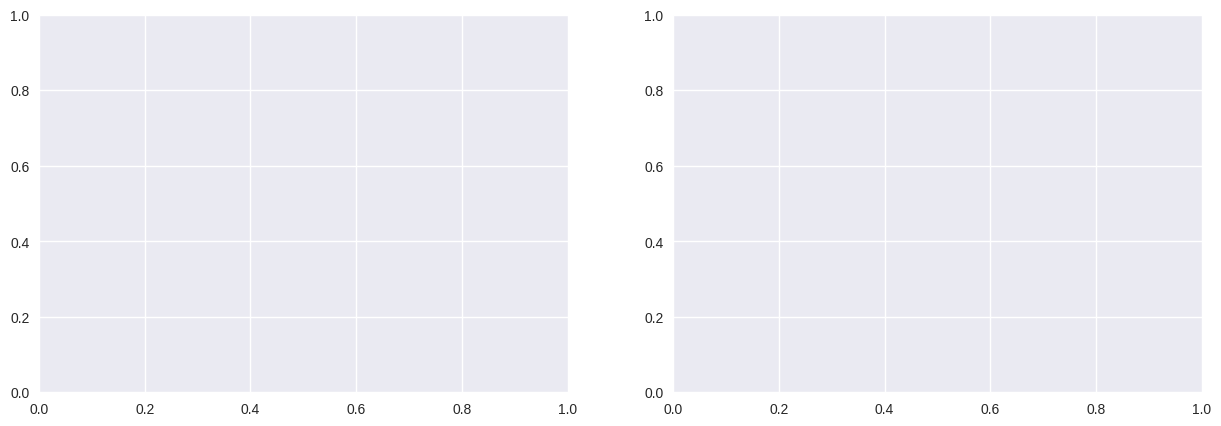

In [ ]:
plt.style.use('seaborn')
fig, axs = plt.subplots(1,2, figsize=(15,5), dpi=100)
axs[0].plot(history.history['accuracy'], color='r', label='train')
axs[0].plot(history.history['val_accuracy'], color='b', label='validation')
axs[0].legend(loc = 'upper left', prop={'size':12})
axs[0].set_title('ACCURACY', fontsize=20)
axs[1].plot(history.history['loss'], color='r', label='train')
axs[1].plot(history.history['val_loss'], color='b', label='validation')
axs[1].set_title('LOSS', fontsize=20)
axs[1].legend(loc = 'upper right', prop={'size':12})
fig.savefig(TRIAL_PATH+'/ACCURACY and LOSS')

# Save model

In [ ]:
clf.save(TRIAL_PATH+'/model_'+TRIAL_NUMBER+'.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Analysing model results

In [ ]:
from keras.utils import np_utils
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix

predictions = clf.predict([X_test,X_test, qual_test])

mult_label = []
for prediction in predictions:
  mult_label.append(np.where(prediction > 0.4, 1, 0))

etiq = []
[etiq.append(abbv) for abbv in csv_file['Abbreviation']]
clf_rep = classification_report(y_test, mult_label, target_names=etiq)
print(classification_report(y_test, mult_label,target_names=etiq))

              precision    recall  f1-score   support

        IAVB       0.50      0.13      0.21      3599
          AF       0.60      0.63      0.62      5894
         AFL       0.52      0.18      0.27       472
       Brady       0.55      0.28      0.37       808
       CRBBB       0.49      0.14      0.22       972
       IRBBB       0.46      0.03      0.05      2070
       LAnFB       0.51      0.10      0.17      2190
         LAD       0.52      0.24      0.33      7516
        LBBB       0.67      0.44      0.53      1614
       LQRSV       0.41      0.02      0.04       643
      NSIVCB       0.43      0.02      0.03      1140
          PR       0.63      0.33      0.43       374
         PAC       0.47      0.18      0.26      3429
         PVC       0.45      0.13      0.21       557
         LPR       0.24      0.01      0.02       394
         LQT       0.38      0.13      0.19      1757
         QAb       0.36      0.02      0.05      1196
         RAD       0.49    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = multilabel_confusion_matrix(y_test, mult_label)

# Generating a confusion matrix for class predictions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title(class_label)

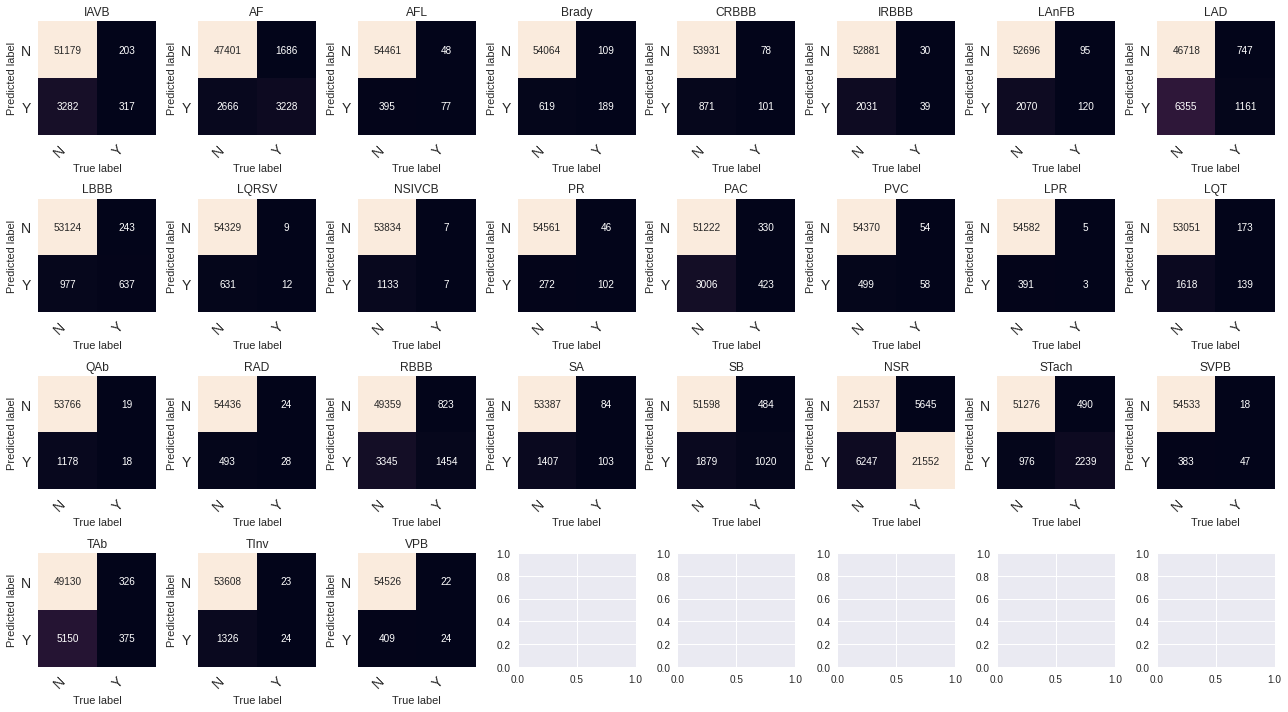

In [ ]:
csv_file = pd.read_csv('/content/drive/MyDrive/TFM_DATA/Dx_snomed_valid.csv', delimiter=';')
labels=csv_file['Abbreviation']
fig, ax = plt.subplots(4, 8, figsize=(18, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.savefig(TRIAL_PATH+'/confusion_matrix')
plt.show()  

# Saving the model results

In [ ]:
def txt_generator():
    with open(os.path.join(TRIAL_PATH, FILE_NAME), 'w') as f:
      f.write(TRIAL_NUMBER+'\n')
      f.write('Training this model took ' + str(float(time_spend/60))+' minutes...\n')
      f.write('--------------------------------------------------------'+'\n')
      f.write('Dataset used: ' + DATASET + '\n')
      f.write('Data dimensions'+'\n')
      f.write('\tTrain: '+'\n')
      f.write('\t\t'+'ECG: '+ str(X_train.shape)+'\n')
      f.write('\t\t'+'Qualitative: '+str(qual_train.shape)+'\n')
      f.write('\t\t'+'Labels: '+str(y_train.shape)+'\n')
      f.write('\tValidation: '+'\n')
      f.write('\t\t'+'ECG: '+str(X_val.shape)+'\n')
      f.write('\t\t'+'Qualitative: '+str(qual_val.shape)+'\n')
      f.write('\t\t'+'Labels: '+str(y_val.shape)+'\n')
      f.write('\tTest: '+'\n')
      f.write('\t\t'+'ECG: '+str(X_test.shape)+'\n')
      f.write('\t\t'+'Qualitative: '+str(qual_test.shape)+'\n')
      f.write('\t\t'+'Labels: '+str(y_test.shape)+'\n')
      f.write('Hyper Parameters\n')
      f.write('\t\t'+'Learning Rate '+ str(learning_rate) +'\n')
      f.write('\t\t'+'Drop Out '+str(dropout) +'\n')
      f.write('\t\t'+'Batch Normalisation '+str(batch_norm) +'\n\n')
      f.write('Clasification Report'+'\n')
      f.write(str(clf_rep)+'\n\n')

In [ ]:
txt_generator()

# Loading existing model

In [ ]:
clf = load_model(TRIAL_PATH+'/model_' + TRIAL_NUMBER + '.h5')

# ROC curves and AUC calculations

In [ ]:
m1_probs = clf.predict([X_test,X_test,qual_test])
m1_probs

array([[4.9795460e-02, 1.5057113e-02, 6.7782557e-06, ..., 6.4358965e-02,
        7.0882291e-03, 1.8333546e-04],
       [3.7807692e-02, 4.0571862e-03, 1.2302819e-05, ..., 2.8356768e-02,
        5.8325073e-03, 3.0354326e-04],
       [1.4076537e-01, 5.6885383e-03, 1.0154756e-03, ..., 5.8346573e-02,
        1.5925003e-02, 5.0976669e-04],
       ...,
       [2.6905969e-01, 7.3255273e-03, 3.8571619e-05, ..., 2.1274698e-01,
        5.2151427e-02, 2.9025655e-03],
       [5.1907916e-03, 5.1402458e-04, 1.2231072e-04, ..., 1.0522898e-01,
        1.2870918e-02, 1.4590819e-03],
       [2.9469702e-01, 2.3137641e-03, 1.7940476e-04, ..., 2.1379625e-02,
        1.6142473e-02, 1.5961488e-05]], dtype=float32)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

m1_auc = roc_auc_score(y_test, m1_probs)
m1_auc

0.859417229687668

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(27):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], m1_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), m1_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

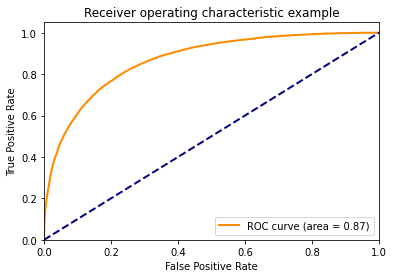

In [ ]:
plt.figure()
lw = 2
clase = 21
plt.plot(fpr[clase], tpr[clase], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[clase])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
clase = 21
for clase, valor in roc_auc.items():
  print(clase)
  print(valor)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc

m1_probs = clf.predict([X_test,X_test,qual_test])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(27):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], m1_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), m1_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
clase = 21
plt.plot(fpr[clase], tpr[clase], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[clase])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

clase = 21
for clase, valor in roc_auc.items():
  print(clase)
  print(valor)
